# tangleGen demo for the 1000 Genomes project

Simple script for the exemplary application of tangleGen to the 1000 Genomes 
project, phase 3. The SNPs are reduced to SNPs in Kidd's AIMs panel, AMR populations 
are excluded resulting in 2157 sampled individuals. Demo script is structured as 
follows:

    1. Imports
    2. Set parameters
    3. Load data
    4. Preprocess data
    5. Constructing cuts
    6. Computing costs
    7. Constructing the tangles tree: For each cut compute the tangles by expanding on 
        the previous ones if it is consistent. If its not possible stop
    8. Read out typical genome 
    9. Compute characterizing cuts
    10. Postprocess in soft clustering and plot


In [1]:
import pickle
import sys
from functools import partial
import numpy as np
import pandas as pd
import compute_kNN
import plot_soft_clustering
import read_vcf
import reliability_factor
from src import cost_functions, data_types, utils, tree_tangles
sys.path.append('..')

### Set parameters.

In [2]:
n = 2157                    # number of individuals
agreement = 225             # agreement parameter
cost_fct = "FST_kNN"        # choice of cost function
k = 40                      # k for k-nearest neighbours
pruning = 0                 # pruning parameter

### Load data.

In [3]:
# load data from 1000 Genomes project (phase 3) reduced to SNPs in Kidd's AIMs panel,
# AMR populations excluded:
aims_data = read_vcf.ReadVCF(n, 'AIMs', 'AIMs_kidd_no_AMR', 'data/vcf/')
aims_data.read_vcf()

# get genotype matrix and embed data into tangles framework:
xs = np.transpose(aims_data.G[0])   # diploid genotype matrix
data = data_types.Data(xs=xs)       # embed aims_data in tangles framework

### Preprocess data.
Since the individuals in aims_data are sorted according to their 
population membership, the vector of population memberships must be 
sorted in the same way:

In [4]:
# get population membership for each individual (individuals in vcf file are also
# sorted by populations, i.e. same sorting):
panel_file = ('data/vcf/integrated_call_samples_v3.20130502.ALL.panel')
panel_df = pd.read_csv(panel_file, delimiter='\t')
sample_pop = panel_df['pop']
pop_array = np.array(sample_pop)
custom_order = {'YRI': 0, 'LWK': 1, 'GWD': 2, 'MSL': 3, 'ESN': 4, 'ASW': 5,
                'ACB': 6, 'FIN': 7, 'CEU': 8, 'GBR': 9, 'TSI': 10, 'IBS': 11,
                'GIH': 12, 'PJL': 13, 'BEB': 14, 'STU': 15, 'ITU': 16, 'CHB': 17,
                'JPT': 18, 'CHS': 19, 'CDX': 20, 'KHV': 21, 'MXL': 22, 'PUR': 23,
                'CLM': 24, 'PEL': 25}
custom_sort_criteria = np.array([custom_order[pop] for pop in pop_array])
sorted_indices = np.argsort(custom_sort_criteria)
pop_membership = pop_array[sorted_indices]
pop_membership = pop_membership[:2157]  # exlcude AMR pops from pop_membership array
print("population membership of individuals after resorting (AMR populations excluded)"
      ":\n", pop_membership, flush=True)

population membership of individuals after resorting (AMR populations excluded):
 ['YRI' 'YRI' 'YRI' ... 'KHV' 'KHV' 'KHV']


## Constructing cuts.
Compute a set of bipartitions or cuts from the data:

In [5]:
print("Generating set of bipartitions.", flush=True)
bipartitions = data_types.Cuts(values=(data.xs > 0).T,
                                names=np.array(list(range(0, data.xs.shape[1]))))
print("Found {} bipartitions.".format(len(bipartitions.values)), flush=True)

Generating set of bipartitions.
Found 55 bipartitions.


### Compute costs.
The cost function uses the k-nearest neighbours matrix, which is computed and saved 
in this step:

In [6]:
kNN = compute_kNN.KNearestNeighbours(xs, k, filename="kNN_AIMs_panel",
                                             filepath="data/saved_kNN/")
kNN.compute_kNN()
# pickle kNN-Matrix for cost function to load:
with open("data/saved_kNN/kNN", 'wb') as outp:
    pickle.dump(kNN, outp, pickle.HIGHEST_PROTOCOL)

With this, we can compute the costs of all cuts and sort them accordingly:

In [7]:
print("Calculating costs of bipartitions.")
cost_function = getattr(cost_functions, cost_fct)
bipartitions = utils.compute_cost_and_order_cuts(bipartitions, partial(cost_function,
                                                                       data.xs, None))

Calculating costs of bipartitions.
Computing costs of cuts...


100%|██████████| 55/55 [00:01<00:00, 27.53it/s]


Check for duplicate cuts and merge if necessary (this step can reduce the run time 
significantly):

In [8]:
print("Merging doublicate mutations.")
bipartitions = utils.merge_doubles(bipartitions)
print("Number of bipartitions after merging:", len(bipartitions.names))

Merging doublicate mutations.
Number of bipartitions after merging: 55


### Construct tangles search tree.

Building the tangle search tree
Built tree has 4 leaves


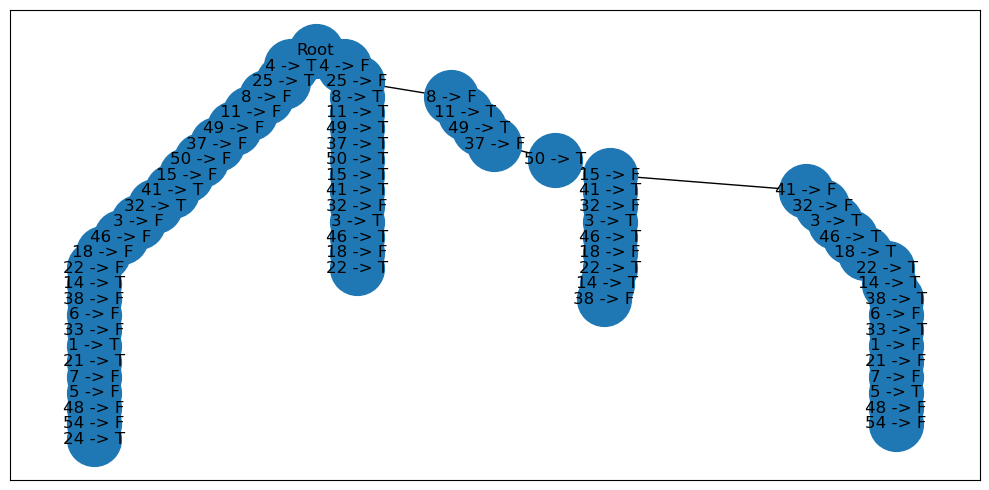

In [9]:
print("Building the tangle search tree", flush=True)
tangles_tree = tree_tangles.tangle_computation(cuts=bipartitions, agreement=agreement, 
                                       verbose=0)
print("Built tree has {} leaves".format(len(tangles_tree.maximals)), flush=True)
### uncomment if you have graphvis installed on your system
tangles_tree.plot_tree()

Postprocess the tangles search tree by contracting paths:

Postprocessing the tree.
Contracting to binary tree


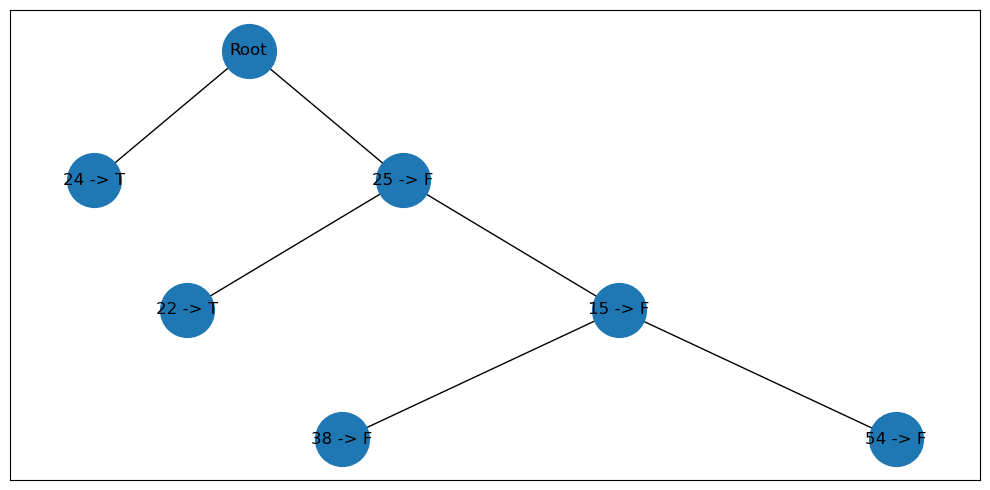

In [10]:
# postprocess tree
print("Postprocessing the tree.", flush=True)
# contract to binary tree
print("Contracting to binary tree", flush=True)
contracted_tree = tree_tangles.ContractedTangleTree(tangles_tree)
### uncomment if you have graphvis installed on your system
contracted_tree.plot_tree()

### Read out cluster-typical genome. 

In [11]:
# identified populations (assign automatically in the future): 
id_pops = ["EAS", "SAS", "EUR", "AFR"]
# read out cluster-typical genome:
for c in range(len(tangles_tree.maximals)):
    print("cluster-typical genome of ", id_pops[c], ":",tangles_tree
          .maximals[c]
          .tangle.get_specification(), flush=True)
print("0 means that the cluster-typical genome is homozygous for the ancestral"
      " allele at the SNP corresponding to the SNP index, otherwise 1.", flush=True)
# print corresponding SNP index:
print("\nSNP index in cluster-typical genomes:\n", tangles_tree.maximals[0].tangle
      .get_cuts
().names, flush=True)

cluster-typical genome of  EAS : bitarray('00111111101101')
cluster-typical genome of  SAS : bitarray('0001101010110110')
cluster-typical genome of  EUR : bitarray('000110100011111101000100')
cluster-typical genome of  AFR : bitarray('1100000011000010001100001')
0 means that the cluster-typical genome is homozygous for the ancestral allele at the SNP corresponding to the SNP index, otherwise 1.

SNP index in cluster-typical genomes:
 ['4' '25' '8' '11' '49' '37' '50' '15' '41' '32' '3' '46' '18' '22' '14'
 '38' '6' '33' '1' '21' '7' '5' '48' '54' '24' '9' '28' '16' '51' '27'
 '10' '29' '26' '23' '53' '30' '13' '44' '47' '43' '34' '40' '39' '36'
 '31' '17' '52' '20' '12' '0' '42' '2' '35' '19' '45']


### Calculate set of characterizing cuts.

In [12]:
# calculate set of characterizing cuts:
print("Calculating set of characterizing bipartitions.", flush=True)
contracted_tree.calculate_setP()

Calculating set of characterizing bipartitions.


In [13]:
# prune short paths:
contracted_tree.prune(bipartitions, pruning)
contracted_tree.calculate_setP()

	4 clusters after cutting out short paths.


### Compute soft clustering.

In [14]:
# assign weight/ importance to bipartitions. no weights used for soft clustering in population genetics:
weight = np.ones(len(bipartitions.names))
# calculate the soft clustering, i.e. soft predictions:
print("Calculating soft predictions", flush=True)
tree_tangles.compute_soft_predictions_children_popgen(node=contracted_tree.root, 
                                         cuts=bipartitions, weight=weight, 
                                         cuts_probs=reliability_factor.compute_reliability(
                                                 xs), verbose=3)
contracted_tree.processed_soft_prediction = True

Calculating soft predictions


Convert the soft clustering to be able to plot in a stacked bar plot:

In [15]:
# get matrix with hierarchical soft clustering along the tangles tree to plot
# this inferred ancestry. char_cuts are the characteristic SNPs per split in
# the tangles tree, posititions indicate the position of the split in the tree.
matrices, char_cuts, positions = contracted_tree.to_matrix()

# get number of characterizing SNPs per split (necessary as bipartitions have been 
# merged):
num_char_cuts_per_split = []
for k in range(1, len(list(char_cuts.keys())) + 1):
    num_char_cuts_per_split.append(np.sum(np.array( [name.count(",") + 1 for name in 
                                                     bipartitions.names[list(char_cuts[k].keys())]])))
num_char_cuts = dict(zip(char_cuts.keys(), num_char_cuts_per_split))
print("number of characterizing cuts per split in tangles tree:", 
      num_char_cuts_per_split, flush=True)

number of characterizing cuts per split in tangles tree: [9, 3, 3]


Calculate hard predictions:

In [16]:
print("Calculating hard predictions", flush=True)
ys_predicted, _ = utils.compute_hard_predictions(contracted_tree, cuts=bipartitions)

Calculating hard predictions


### Plot the soft clustering.

Plotting the soft clustering, this step may take about 30 seconds.
sort the indv. per population according to the finest-grained clustering and keep this sorting for all other clustering levels.
data sorting done.


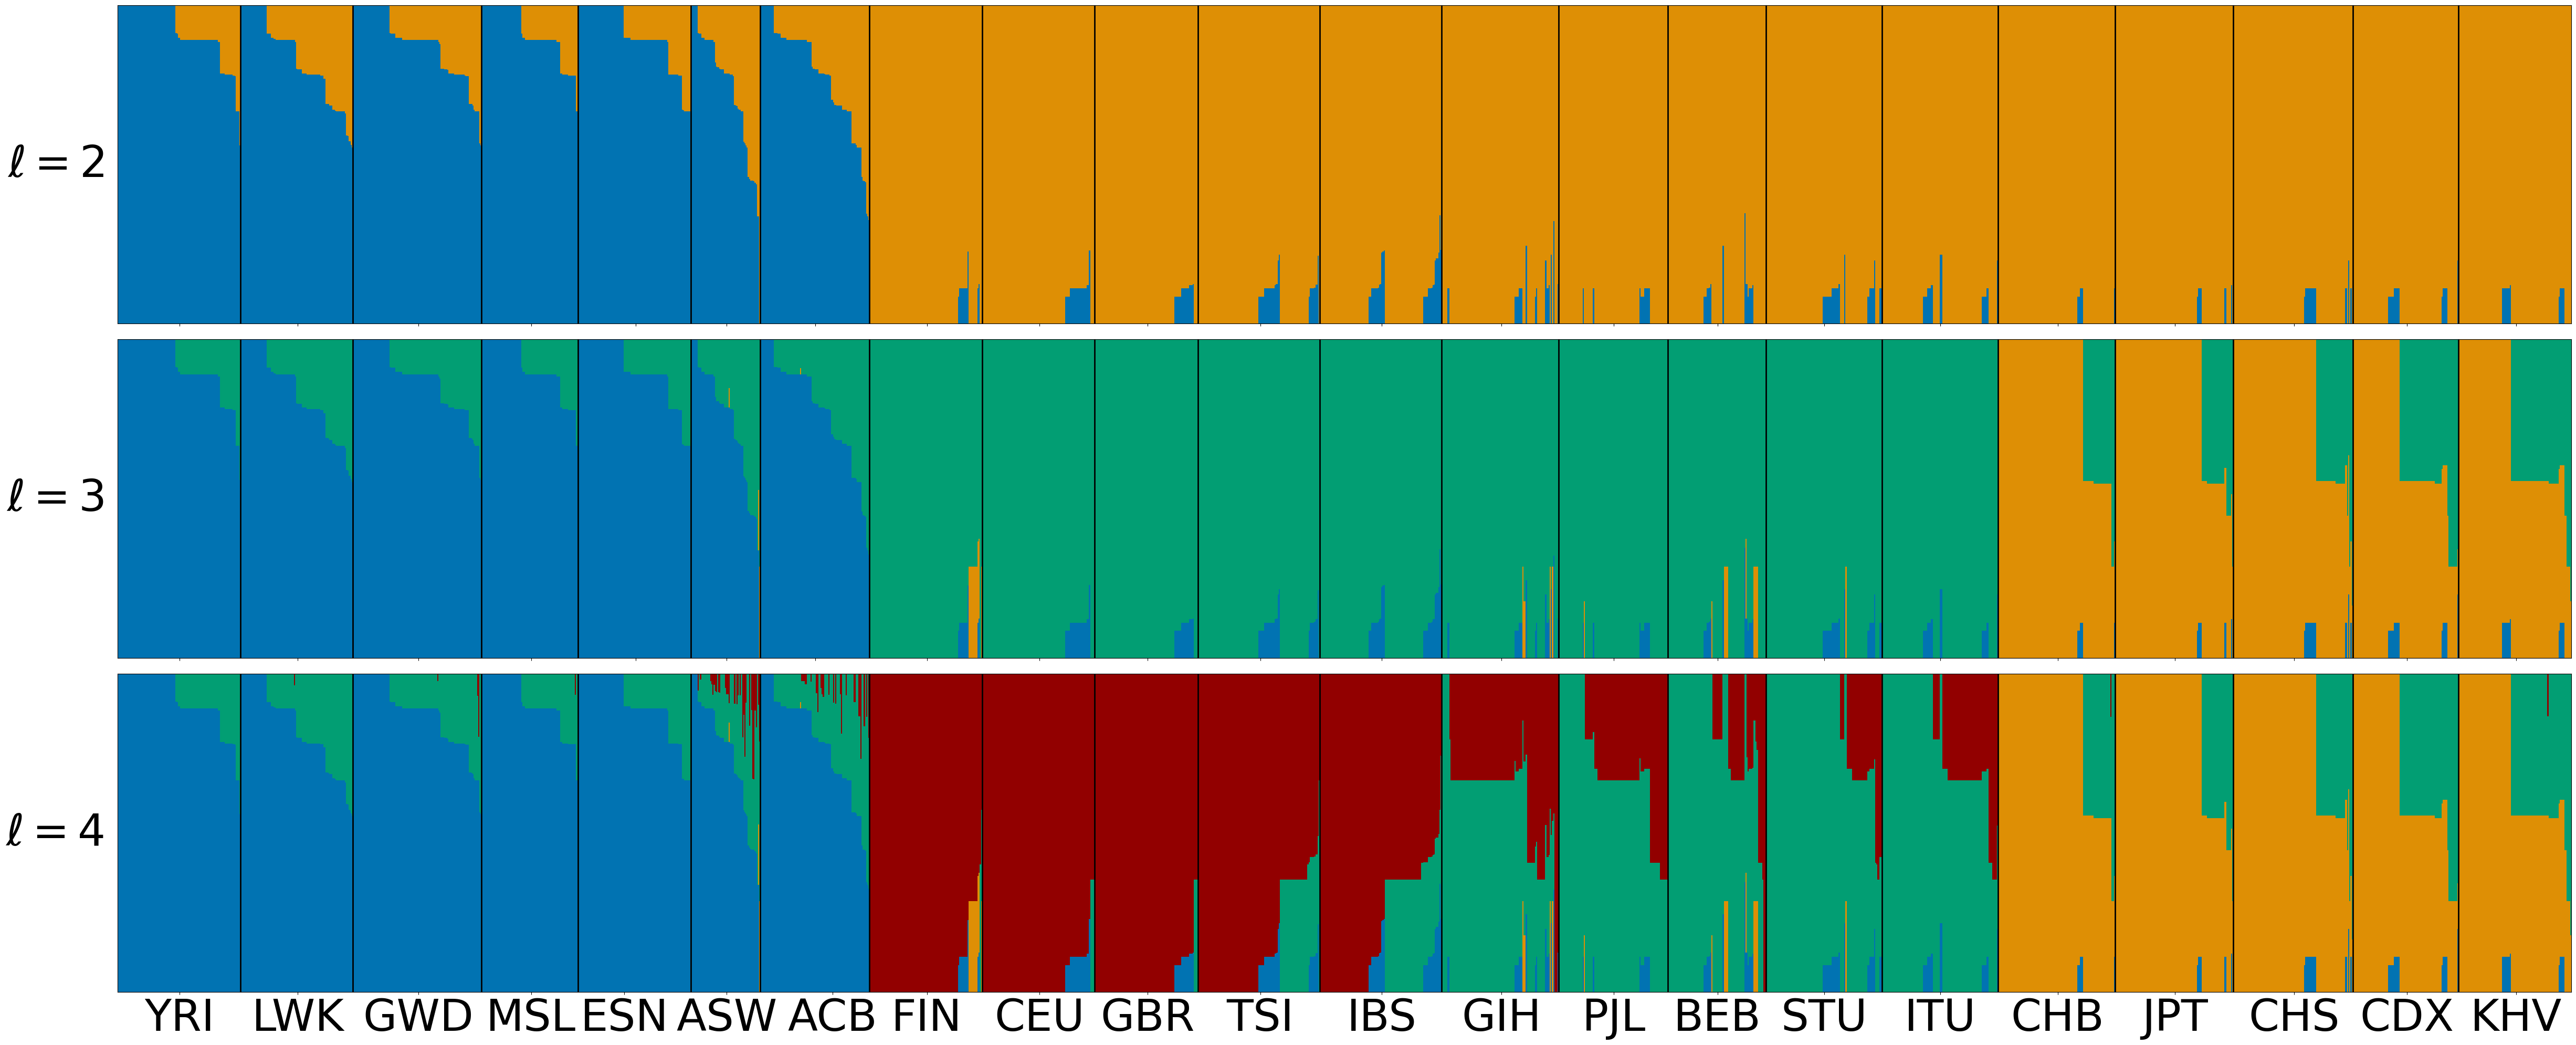

In [17]:
print("Plotting the soft clustering, this step may take about 30 seconds.", flush=True)
plot_soft_clustering.plot_inferred_ancestry(matrices, pop_membership, agreement, "readVCF", cost_fct=cost_fct)